In [4]:
import numpy as np
from iminuit import Minuit
import matplotlib.pyplot as plt
from scipy.linalg import inv

In [5]:
# Observed values and their uncertainties
observed = np.array([-9.3, -1.3, 5.7, 6.5])
errors = np.array([8.2, 8.4, 8.2, 8.3])

# Correlation matrix
corr = np.array([
    [1, -0.1, -0.05, 0.1],
    [-0.1, 1, 0.1, -0.05],
    [-0.05, 0.1, 1, 0.1],
    [0.1, -0.05, 0.1, 1]
])

# Covariance matrix
cov_matrix = np.outer(errors, errors) * corr
inv_cov = inv(cov_matrix)

In [6]:
# Define the model functions
def model(gamma, r, delta):
    x_plus = r * np.cos(delta + gamma)
    y_plus = r * np.sin(delta + gamma)
    x_minus = r * np.cos(delta - gamma)
    y_minus = r * np.sin(delta - gamma)
    return np.array([x_plus, y_plus, x_minus, y_minus])

In [7]:
# Negative log-likelihood function
def neg_log_likelihood(gamma, r, delta):
    predicted = model(gamma, r, delta)
    diff = observed - predicted
    return 0.5 * diff @ inv_cov @ diff

In [8]:
# Initialize and minimize using Minuit
m = Minuit(neg_log_likelihood, gamma=0.1, r=10, delta=0.1)
m.limits["r"] = (0, None)  # r must be positive
m.migrad()  # Minimize
m.hesse()   # Compute uncertainties

# Extract parameter estimates and uncertainties
gamma_est, r_est, delta_est = m.values["gamma"], m.values["r"], m.values["delta"]
gamma_err, r_err, delta_err = m.errors["gamma"], m.errors["r"], m.errors["delta"]

# Print results
print(f"Estimated gamma: {gamma_est} ± {gamma_err}")
print(f"Estimated r: {r_est} ± {r_err}")
print(f"Estimated delta: {delta_est} ± {delta_err}")

# Covariance matrix of the estimates
cov_matrix_est = m.covariance
print("\nCovariance Matrix of Estimates:")
print(cov_matrix_est)

Estimated gamma: -1.9259587995540766 ± 0.844623744245757
Estimated r: 9.015322970648558 ± 8.087469666860152
Estimated delta: -1.0710543279778189 ± 0.9560993969049878

Covariance Matrix of Estimates:
┌───────┬───────────────────┐
│       │ gamma     r delta │
├───────┼───────────────────┤
│ gamma │ 0.713  -0.1   0.0 │
│     r │  -0.1  66.7  -0.8 │
│ delta │   0.0  -0.8 0.914 │
└───────┴───────────────────┘


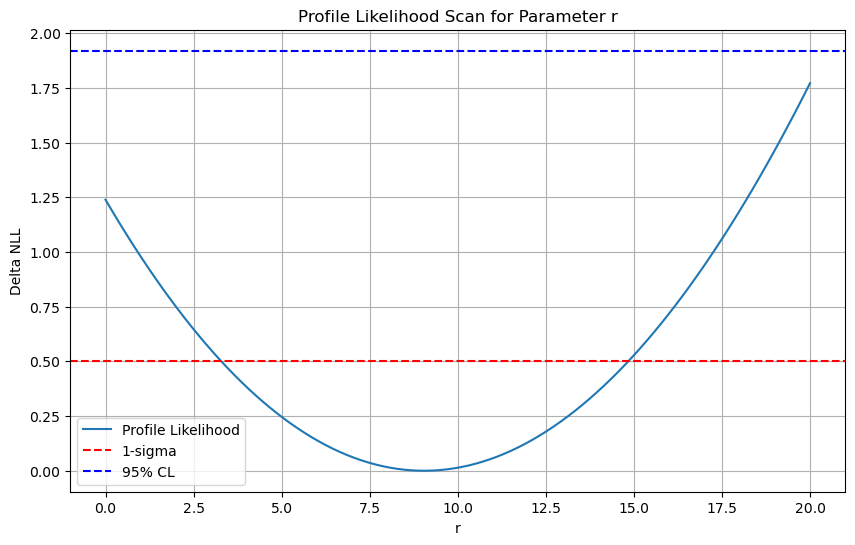

In [9]:
def profile_likelihood(r_values):
    likelihoods = []

    # Loop over different values of r
    for r in r_values:
        # Define the negative log-likelihood function with fixed r
        def neg_log_likelihood_fixed_r(gamma, delta):
            return neg_log_likelihood(gamma, r, delta)

        # Minimize with respect to gamma and delta
        m = Minuit(neg_log_likelihood_fixed_r, gamma=0.1, delta=0.1)
        m.migrad()

        # Store the minimized negative log-likelihood
        likelihoods.append(m.fval)

    return np.array(likelihoods)

# Generate r values for the scan
r_values = np.linspace(0, 20, 100)
likelihoods = profile_likelihood(r_values)

# Plot the profile likelihood scan
min_likelihood = min(likelihoods)
plt.figure(figsize=(10, 6))
plt.plot(r_values, likelihoods - min_likelihood, label="Profile Likelihood")
plt.axhline(0.5, color="red", linestyle="--", label="1-sigma")
plt.axhline(1.92, color="blue", linestyle="--", label="95% CL")
plt.xlabel("r")
plt.ylabel("Delta NLL")
plt.title("Profile Likelihood Scan for Parameter r")
plt.legend()
plt.grid()
plt.show()

In [10]:
n_simulations = 1000
true_gamma = 0.1
coverage_count = 0

for _ in range(n_simulations):
    # Generate synthetic data based on the true parameters
    synthetic_data = np.random.multivariate_normal(observed, cov_matrix)

    # Fit the synthetic data to estimate gamma
    def synthetic_nll(gamma, r, delta):
        return neg_log_likelihood(gamma, r, delta)

    m = Minuit(synthetic_nll, gamma=true_gamma, r=10, delta=0.1)
    m.migrad()
    gamma_est = m.values["gamma"]
    gamma_err = m.errors["gamma"]

    # Check if the true value is within the confidence interval
    if true_gamma >= gamma_est - gamma_err and true_gamma <= gamma_est + gamma_err:
        coverage_count += 1

# Calculate coverage
coverage = coverage_count / n_simulations
print("Estimated Coverage:", coverage)

Estimated Coverage: 0.0


In [11]:
from scipy.optimize import brentq

# Define the function to find the root (where Delta NLL = 1.92)
def delta_nll(r):
    def nll_fixed_r(gamma, delta):
        return neg_log_likelihood(gamma, r, delta)

    m = Minuit(nll_fixed_r, gamma=0.1, delta=0.1)
    m.migrad()
    return m.fval - min_likelihood - 1.92

# Use a root-finding method to find the upper limit
r_upper_limit = brentq(delta_nll, 0, 20)
print("95% Upper Limit on r:", r_upper_limit)

ValueError: f(a) and f(b) must have different signs